In [1]:
from keras.layers import Input,Lambda,Dense, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import tensorflow as tf
import keras.datasets.mnist as mnist
from tqdm import tqdm
import os
from random import shuffle

In [2]:
tf.compat.v1.reset_default_graph()

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               307456    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                2

In [37]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [38]:
train_dir = 'D:\\ProcessedTrainingData'
test_dir = 'D:\\ProcessedTestingData'

In [39]:
def create_training_data():
    training_data = []
    training_data_Y = []
    for j in tqdm(os.listdir(train_dir)):
        for img in tqdm(os.listdir(os.path.join(train_dir,j))):
            path = os.path.join(os.path.join(train_dir,j),img)
            img_arr = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (28,28))
            training_data.append(np.array(img_arr))
            training_data_Y.append(img[0])
    return training_data, training_data_Y
def create_testing_data():
    testing_data = []
    testing_data_Y = []
    for j in tqdm(os.listdir(test_dir)):
        for img in tqdm(os.listdir(os.path.join(test_dir,j))):
            path = os.path.join(os.path.join(test_dir,j),img)
            img_arr = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (28,28))
            testing_data.append(np.array(img_arr))
            testing_data_Y.append(img[0])
    return testing_data, testing_data_Y

In [59]:
#raining_data_X, training_data_Y = create_training_data()[0],create_training_data()[1]
training_data_X = np.array(training_data_X)

In [60]:
testing_data_X, testing_data_Y = create_testing_data()[0],create_testing_data()[1]
testing_data_X = np.array(testing_data_X)

In [40]:
#Create the new training X values by stacking the two data sets
X_train = np.vstack([X_train,X_train,training_data_X])
X_test = np.vstack([X_test,X_test,testing_data_X])

In [41]:
#Create the new training X values by stacking the two data sets
y_train = np.array(np.hstack([y_train,y_train,training_data_Y]),dtype=int)
y_test =  np.array(np.hstack([y_test,y_test,testing_data_Y]),dtype=int)

In [42]:
from random import sample
training_idx = sample(range(0,len(X_train)),len(X_train))
testing_idx = sample(range(0,len(X_test)),len(X_test))

In [43]:
X_train = X_train[training_idx]
X_test = X_test[testing_idx]
y_train = y_train[training_idx]
y_test = y_test[testing_idx]

In [44]:
def add_lines():
    from random import randint,sample
    pix = 28
    arr = np.zeros([pix,pix],dtype='int32')
    num_edges = randint(0,4)
    which_edges = sample(range(0,4),num_edges)
    for i in which_edges:
        if i == 1:
            arr[:,0:2] = 255
        elif i ==2:
            arr[0:2,:] = 255
        elif i == 3:
            arr[:,-2:] = 255
        else:
            arr[-2:,:] = 255

    return arr

In [45]:
def blank_28_28_gen():
    from random import sample
    pix = 28
    arr = np.zeros(pix**2,dtype='int32')
    proportion = np.random.uniform(0,0.1)
    num = int(np.floor(pix**2*proportion))
    rands = list(set(sample(range(0,pix**2),num)))
    arr[rands] = 255
    arr = arr.reshape(pix,pix)
    return arr

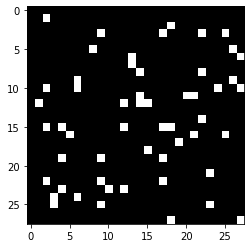

In [46]:
import matplotlib.pyplot as plt
plt.imshow(blank_28_28_gen(),cmap='gray')

In [47]:
y_train_idx = np.where(y_train == 0)[0]
y_test_idx = np.where(y_test == 0 )[0]

In [48]:
for i in y_train_idx:
    X_train[i] = blank_28_28_gen()
for i in y_test_idx:
    X_test[i] = blank_28_28_gen()

In [49]:
i = 0
for i in range(0,len(X_train)):
    X_train[i] = X_train[i]+add_lines()

In [50]:
i = 0
for i in range(0,len(X_test)):
    X_test[i] = X_test[i]+add_lines()

In [51]:
X_train.shape[0], X_test.shape[0]

(180272, 30000)

In [52]:
# We want to edit our data to make it more suitable for Sudoku
# In Sudoku there are only digits from 1-9, 0 = blank
# So, we need to replace all 0s in the training and testing data with blank 28 x 28 with maybe
# some noise

In [53]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [54]:
new_training_set_Y = to_categorical(y_train)
new_testing_set_Y = to_categorical(y_test)

In [55]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [56]:
# Check if GPU is running
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [57]:
# Set Callbacks
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [58]:
# See if it learns
model.fit(X_train,new_training_set_Y, epochs=10, validation_data=(X_test,new_testing_set_Y),callbacks=[callbacks_list])

Epoch 1/10
5634/5634 [==============================] - 34s 6ms/step - loss: 0.1230 - accuracy: 0.9735 - val_loss: 0.0705 - val_accuracy: 0.9817

Epoch 00001: val_accuracy improved from -inf to 0.98170, saving model to weights-improvement-01-0.98.hdf5
Epoch 2/10
5634/5634 [==============================] - 33s 6ms/step - loss: 0.0401 - accuracy: 0.9891 - val_loss: 0.0278 - val_accuracy: 0.9927

Epoch 00002: val_accuracy improved from 0.98170 to 0.99270, saving model to weights-improvement-02-0.99.hdf5
Epoch 3/10
5634/5634 [==============================] - 33s 6ms/step - loss: 0.0285 - accuracy: 0.9923 - val_loss: 0.0490 - val_accuracy: 0.9893

Epoch 00003: val_accuracy did not improve from 0.99270
Epoch 4/10
5634/5634 [==============================] - 32s 6ms/step - loss: 0.0252 - accuracy: 0.9936 - val_loss: 0.0540 - val_accuracy: 0.9891

Epoch 00004: val_accuracy did not improve from 0.99270
Epoch 5/10
5634/5634 [==============================] - 30s 5ms/step - loss: 0.0226 - accur

In [23]:
# loading the model with the least val acc
from keras.models import load_model

model_trained = load_model('weights-improvement-02-0.99.hdf5')

In [24]:
# Evaluate again
model_trained.evaluate(X_test,new_testing_set_Y)

313/313 [==============================] - 1s 3ms/step - loss: 0.0365 - accuracy: 0.9910: 0s - loss:


[0.03654364123940468, 0.9909999966621399]